## Setup

In [54]:
# Check versions of Keras and Tensorflow
!pip list | egrep 'keras|tensorflow$'

keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6


In [55]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

Keras version: 2.15.0, backend: tensorflow
GPUs: 1


In [56]:
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 10
    batch_size = 16
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"
    use_zero_init = True

In [57]:
# Reproducibility
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
#
# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

### Load the data

In [58]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://drive.google.com/uc?export=download&id=1llzvOhjW8dbhqV71iqlQ6xA9pPmbSy8v",
    extract=True,
)

In [59]:
data_path = Path(path_to_downloaded_file).parent / 'images'
!ls {data_path}

A  B  C


In [60]:
class_names = ['A', 'B', 'C']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 64 files belonging to 3 classes.
Using 52 files for training.
Using 12 files for validation.


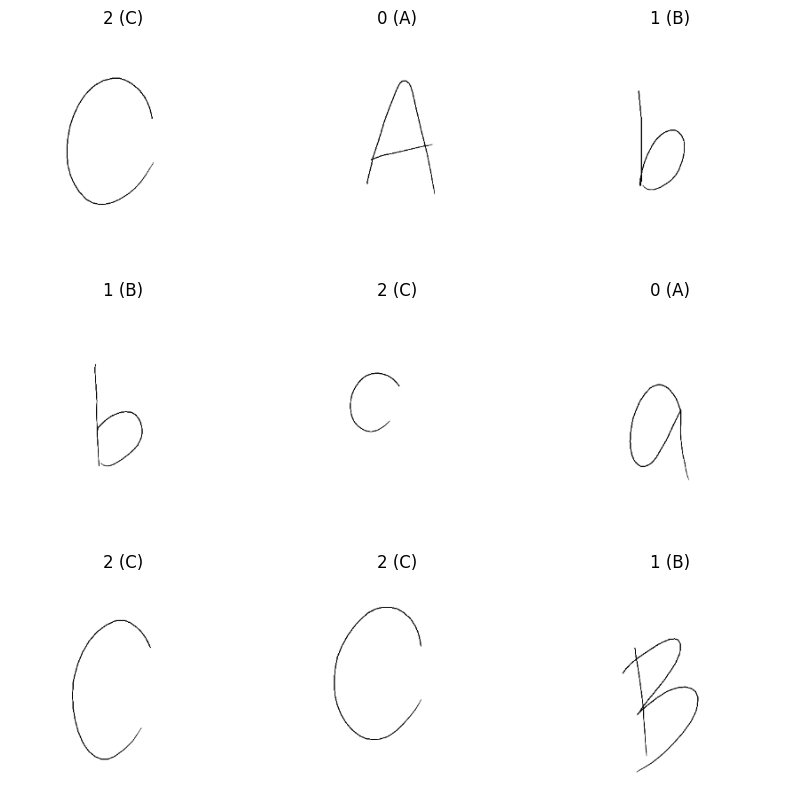

In [61]:
[[example_images, example_labels]] = train_dataset.take(1)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.array(example_images[i]).astype('uint8'))
    label = example_labels[i]
    ax.set(title=f"{label} ({class_names[label]})")
    ax.axis('off')
# Alternative approach (doesn't show labels)
# keras_cv.visualization.plot_image_gallery(example_images, value_range=(0, 255))

### Train a model



In [62]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Zero the output-layer weights (they were randomly initialized, which adds noise to gradients when fine-tuning)
# I was reminded of this by https://twitter.com/wightmanr/status/1742570388016758822
if config.use_zero_init:
    output_layer = model.layers[-1]
    output_layer.set_weights([w * 0 for w in output_layer.weights])

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "image_classifier_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_5 (InputLayer)        [(None, None, None, 3)]   0         Y          
                                                                            
 efficient_net_v2b0_backbon  (None, None, None, 1280   5919312   Y          
 e (EfficientNetV2Backbone)  )                                              
                                                                            
 avg_pool (GlobalAveragePoo  (None, 1280)              0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 3)                 3843      Y          
                                                                            
Total params: 5923155 (22.60 MB)
Trainable param

2024-02-01 04:56:01.985253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inimage_classifier_4/efficient_net_v2b0_backbone/block2b_/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 45s 769ms/step - loss: 1.0691 - accuracy: 0.6923 - val_loss: 1.0581 - val_accuracy: 0.4167
Epoch 2/10
4/4 [==============================] - 0s 112ms/step - loss: 0.7852 - accuracy: 0.9423 - val_loss: 0.9371 - val_accuracy: 0.5833
Epoch 3/10
4/4 [==============================] - 0s 112ms/step - loss: 0.3382 - accuracy: 1.0000 - val_loss: 0.9792 - val_accuracy: 0.5833
Epoch 4/10
4/4 [==============================] - 1s 112ms/step - loss: 0.1164 - accuracy: 1.0000 - val_loss: 0.4334 - val_accuracy: 0.7500
Epoch 5/10
4/4 [==============================] - 0s 114ms/step - loss: 0.0873 - accuracy: 0.9808 - val_loss: 0.2382 - val_accuracy: 0.9167
Epoch 6/10
4/4 [==============================] - 0s 110ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 111ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 1.0000
Epoch 8/10
4/4 [==============

# Predictions

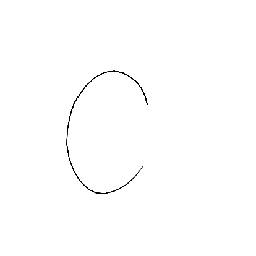

In [83]:
image_file = keras.utils.get_file(origin='https://i.imgur.com/Awllcus.png')
image = keras.utils.load_img(image_file, target_size=(256, 256), keep_aspect_ratio=True)
display(image)

In [84]:
probabilities = model.predict(np.array(image)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 36ms/step


,class,prob
2,C,0.998085
0,A,0.001662
1,B,0.000253


In [ ]:
prob_i = np.argmax(probabilities)
highest_prob_class = class_names[prob_i]
highest_prob = probabilities[prob_i]
result = pd.DataFrame({'class': highest_prob_class, 'prob': highest_prob}, index=[0])
print(result)

# Confusion Matrix

In [79]:
from sklearn.metrics import confusion_matrix

val_predicted_probs = model.predict(val_dataset)
val_predictions = np.argmax(val_predicted_probs, axis=1)
val_labels = [int(label) for img, label in val_dataset.unbatch()]
conf_matrix = confusion_matrix(val_labels, val_predictions)
print(conf_matrix)

1/1 [==============================] - 2s 2s/step
[[5 0 0]
 [0 3 1]
 [0 0 3]]


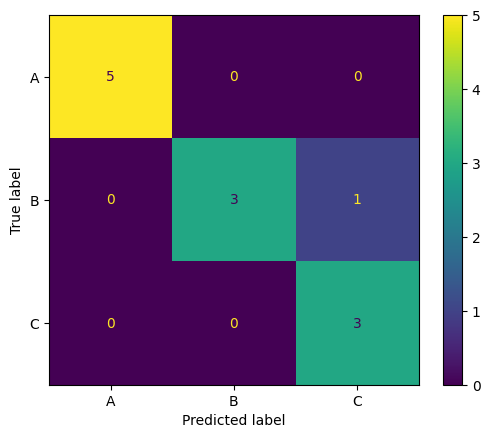

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(val_labels, val_predictions, display_labels=class_names)

# Analysis

### Description


This dataset is a unique collection of images of finger-drawn representations of the letters A, B, and C. There are a total of 3 class: A, B, and C. 
Class A have a total of 20 images. 10 images of capital A and 10 images of lowercase a. Class B have a total amount of 22 images. 10 images of the capital letter B and 12 images of lowercase letter b. The third class, Class C have a total of 22 images of the letter C. 11 images of the capital letter C and 11 images of the lowercase letter c. 

The dataset was collected through the webapp that was provided where I was able to draw with my fingers because of my touch screen laptop. Then, I save them on a folder. Each letter to different folder. 



### Classifier Training and Validation

There are 52 files for training and 12 files for validation.

### Evaluations

* **How accurate is the classifier overall?** Based on the training and validation outcome, the model has an accuracy of 98.08% on the training set and 91.67% on the validation set. The letter A has an accuracy of 100%, the letter B has an accuracy of 91.67%, and the letter C has an accuracy of 91.67%.

* **Which letter is it most successful at classifying?** Based on the confusion matrix, the first class or the letter A is the most successful at classifying.

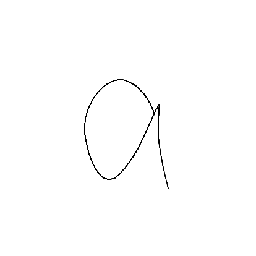

In [85]:
image_file0 = keras.utils.get_file(origin='https://i.imgur.com/tdcETt5.png')
image0 = keras.utils.load_img(image_file0, target_size=(256, 256), keep_aspect_ratio=True)
display(image0)

In [86]:
probabilities = model.predict(np.array(image0)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 41ms/step


,class,prob
0,A,0.977361
2,C,0.017190
1,B,0.005449


* **What mistakes does it make most frequently?** Based on the confusion matrix, the second class or the letter B got mistaken the most at classifying. The true positives class B are 0.

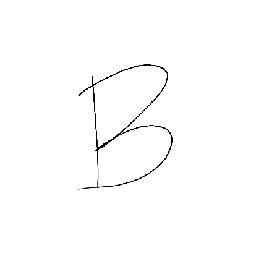

In [87]:
image_file1 = keras.utils.get_file(origin='https://i.imgur.com/Ato3y2c.png')
image1 = keras.utils.load_img(image_file1, target_size=(256, 256), keep_aspect_ratio=True)
display(image1)

In [88]:
probabilities = model.predict(np.array(image1)[np.newaxis, ...])[0]
pd.DataFrame({'class': class_names, 'prob': probabilities}).sort_values('prob', ascending=False)

1/1 [==============================] - 0s 35ms/step


,class,prob
2,C,0.827461
1,B,0.168985
0,A,0.003554


* **For the previous 3 questions, any ideas about why?** Currently, I have a feeling that the reason why that C is easier to classify is because I could not distint a lot of things when writing C and therefore the datasets for the c might look similar. Whereas for letter Bs, I remember drawing a lot more variations for the capital B and A therefore it might be harder for the model that was trained to adapt to the differences with only limited datasets. 

* **Generalization: Suppose someone else gave you one of their images. How likely do you think your classifier would be to get it right, and why? report your answer in terms of a percentage, either overall or broken down by which letter.** I thinnk if someone else gave me one of their images, it will depends on whether it landed on the training or validation. If it landed in the training I doubt that one image will impact the percentage of the validation accuracy. But if it landed on the validation, I think the accuracy of it will go down since my our handwritting will be very different. If the image is of the letter A, the classifier would have a 100% chance of getting it right. If the image is of the letter B, the classifier would have less than 91% chance of getting it right. If the image is of the letter C, the classifier would have a less 91% chance of getting it right.

### Choices

* **What choices did you have to make in the process of collecting data, processing it, and analyzing the results?** During the process of collecting data, the choices that I had to make was to start or at least make sure that the majority of the datasets are in the middle of the image. I also have to make a choice on how much data set I wanted to collect overall. At first I wanted to collect each classes to have 20 images in total. But then I decided increase the number of image by one for different class. When analyzing the result, I have to choose on different visualization in order to fully conclude the report.

* **What are one or two choices that you could have made differently?** One choice that I would have made differently is the number of images that I would do.

* **What do you expect would be different if you made that different choice?** I would expect that the number of validation accuracy would increase if the model have more training images. 
